In [69]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cloud_func_lib as cfl
import csv

In [ ]:
def get_blqv(ds, blz_ind, t):
    '''
    Taking the mean up to the cloud base looks a little bit better, all the points are higher in the model. Vs, the whole BL, then it's better at the higher qv and worse at the low qv. 
    '''
    #return ds.q_vapour[t].where(ds.z<bl_z).mean().values*1000
    #return ds.q_vapour[t,:,:,:blz_ind].mean().values*1000
    return ds.q_vapour[t,:,:,:np.argmin(np.abs(ds.z.values - np.mean(ds.clbas.where(ds['clbas']!=0.0), axis=(1,2))[0].values))].mean().values*1000  # taking the average up to the cloud base. 
    
def get_blz(ppe_no, t):
    return np.loadtxt(f"/home/users/eers/sct/lwp_mask_csvs/sct_em{ppe_no}_inv_height.csv")[t]

def get_deltatheta(ds, bl_z, t):
    diff = ds.theta_mean[t, np.argmin(np.abs(ds.z.values - bl_z))]- ds.theta_mean[t, 1]
    return diff.values

def get_deltaqv(ds, bl_z, blqv, t):
    return ds.q_vapour[t,:,:,np.argmin(np.abs(ds.z.values - bl_z))+5].mean(axis=(0,1)).values*1000 - blqv
    return diff

def get_na(ds, t):
    return ds.q_accum_sol_number[t,:,:,1:].where(ds.z<500).mean().values*1e-6

def get_baut(ds):
    return float(ds.options_database[cfl.find_options(ds, b"b_aut")[0]].values[1])

def get_shallow_grad(ds, tstep):
    '''
    This function works from the top down, hence why the return value is multiplied by minus 1.
    '''
    da=ds.theta_mean[tstep, 5:]
    
    grads = []
    for j in range(1,len(ds.zn[5:])):
        g = (ds.zn.values[-1] - ds.zn.values[-1-j])/(da.values[-1] - da.values[-1-j])
        grads.append(np.abs(g))

    return -1*np.argmin(grads)   

def get_deltheta_thresh(ds, tstep):
    '''
    Finds the top of the subcloud layer using a threshold. 
    For each layer it calculates the diff between the pot temp and the mean of the layers below, if it's over 0.15K then it stops. Defined by Anna Lea Albright's paper.
    Finds shallowest gradient and then adds 20 layers to clear the transition to FT. 
    '''
    da=ds.theta_mean[tstep, 5:]
    
    subcloud_top=5
    while np.abs(da[subcloud_top] - np.mean(da[:subcloud_top])) < 0.15 and subcloud_top < len(ds.zn[5:-1]):
        subcloud_top+=1
    
    inv_ind = get_shallow_grad(ds, tstep) 
    diff = ds.theta_mean[tstep, inv_ind+20] - ds.theta_mean[tstep, :subcloud_top].mean()
    return subcloud_top, inv_ind, diff.values

def get_delqv_thresh(ds, tstep):
    da=ds.vapour_mmr_mean[tstep, 5:]
    
    subcloud_top=5
    while np.abs(da[subcloud_top] - np.mean(da[:subcloud_top])) < 0.35e-3 and subcloud_top < len(ds.zn[5:-1]):
        subcloud_top+=1
        
    min_grad = np.argmin(np.gradient(da.values))

    if min_grad < 240:
        inv_ind = min_grad+20
    else:
        inv_ind = min_grad
    
    diff = (da[inv_ind] - da[:subcloud_top].mean())*1e3
    return subcloud_top, min_grad, diff.values


Text(0.5, 0.01, 'LH Design')

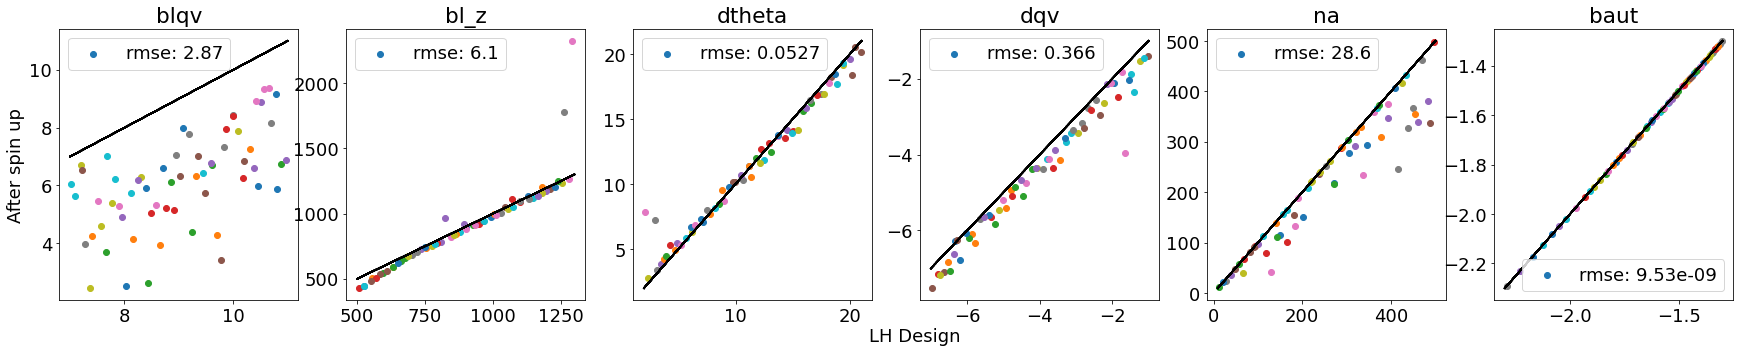

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=6,figsize=(30,5))

t = 1
design = np.loadtxt("/home/users/eers/sct/lh_design/SCT_EmulatorInputsDesign.csv", skiprows=1, delimiter=',')
diff_dict = {'blqv': [(7, 11), np.empty((61))], 'bl_z': [(500, 1300), np.empty((61))], 'dtheta': [(2, 21), np.empty((61))], 
             'dqv': [(-7, -1), np.empty((61))], 'na': [(10, 500), np.empty((61))], 'baut': [(-2.3, -1.3), np.empty((61))]}

for i in range(61):
    ds = xr.open_dataset(f"/gws/nopw/j04/carisma/eers/sct/em/em{i}/sct_em{i}_merged.nc")

    dt_subcloud_top, dt_blz_ind, diff_dict['dtheta'][1][i] = get_deltheta_thresh(ds, t)
    dqv_subcloud_top, dqv_inv_ind, diff_dict['dqv'][1][i] = get_delqv_thresh(ds, t)
    diff_dict['bl_z'][1][i] = ds.zn[dqv_inv_ind]
    #diff_dict['blqv'][1][i] = ds.vapour_mmr_mean[t,5:dqv_inv_ind].mean()*1e3
    diff_dict['blqv'][1][i] = ds.vapour_mmr_mean[t,5:].where(ds.z<500).mean()*1e3
    diff_dict['na'][1][i] = ds.q_accum_sol_number[t,:,:,1:dqv_inv_ind].mean().values*1e-6 # get_na(ds, t) OR ds.q_accum_sol_number[t,:,:,1:dt_blz_ind].mean().values*1e-6
    diff_dict['baut'][1][i] = get_baut(ds)

    for j,(key,val) in enumerate(diff_dict.items()):
        p=ax[j].scatter(design[i][j], val[1][i])
        ax[j].plot(val[0], val[0], c='black')
        ax[j].set_title(key)

    ds.close()

for j,(key,val) in enumerate(diff_dict.items()):
    rmse = (np.mean(design[:,j] - val[1][:])**2)**0.5
    ax[j].legend([p],[f"rmse: {rmse:0.3}"])
    
ax[0].set_ylabel("After spin up")
fig.text(0.5,0.01,"LH Design")

In [67]:
fig.savefig("compare_spinup_thresholdvals_qv0035_nadinv_dqvinv_blqv500m.png")

### Plots showing the calculated subcloud top and transition top

In [27]:
ds = xr.open_dataset("/gws/nopw/j04/carisma/eers/sct/em/em0/sct_em0_merged.nc")
ds = cfl.ds_fix_dims(ds)

da = ds.theta_mean[0,5:]
da_q = ds.vapour_mmr_mean[0,5:]

m1 = min(da)
m2 = max(da)

q1 = min(da_q)
q2 = min(da_q)

In [93]:
heights=[]
qv_prof=[]
th_prof=[]
with open('master_ppe_input_csvs/string_master_array.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='|')
    line_count=0
    for row in csv_reader:
        if line_count!=0:
            heights.append([float(i) for i in row[1].split(',')])
            th_prof.append([float(i) for i in row[2].split(',')])
            qv_prof.append([float(i)*1e3 for i in row[3].split(',')][:len(heights[line_count-1])])
        line_count+=1

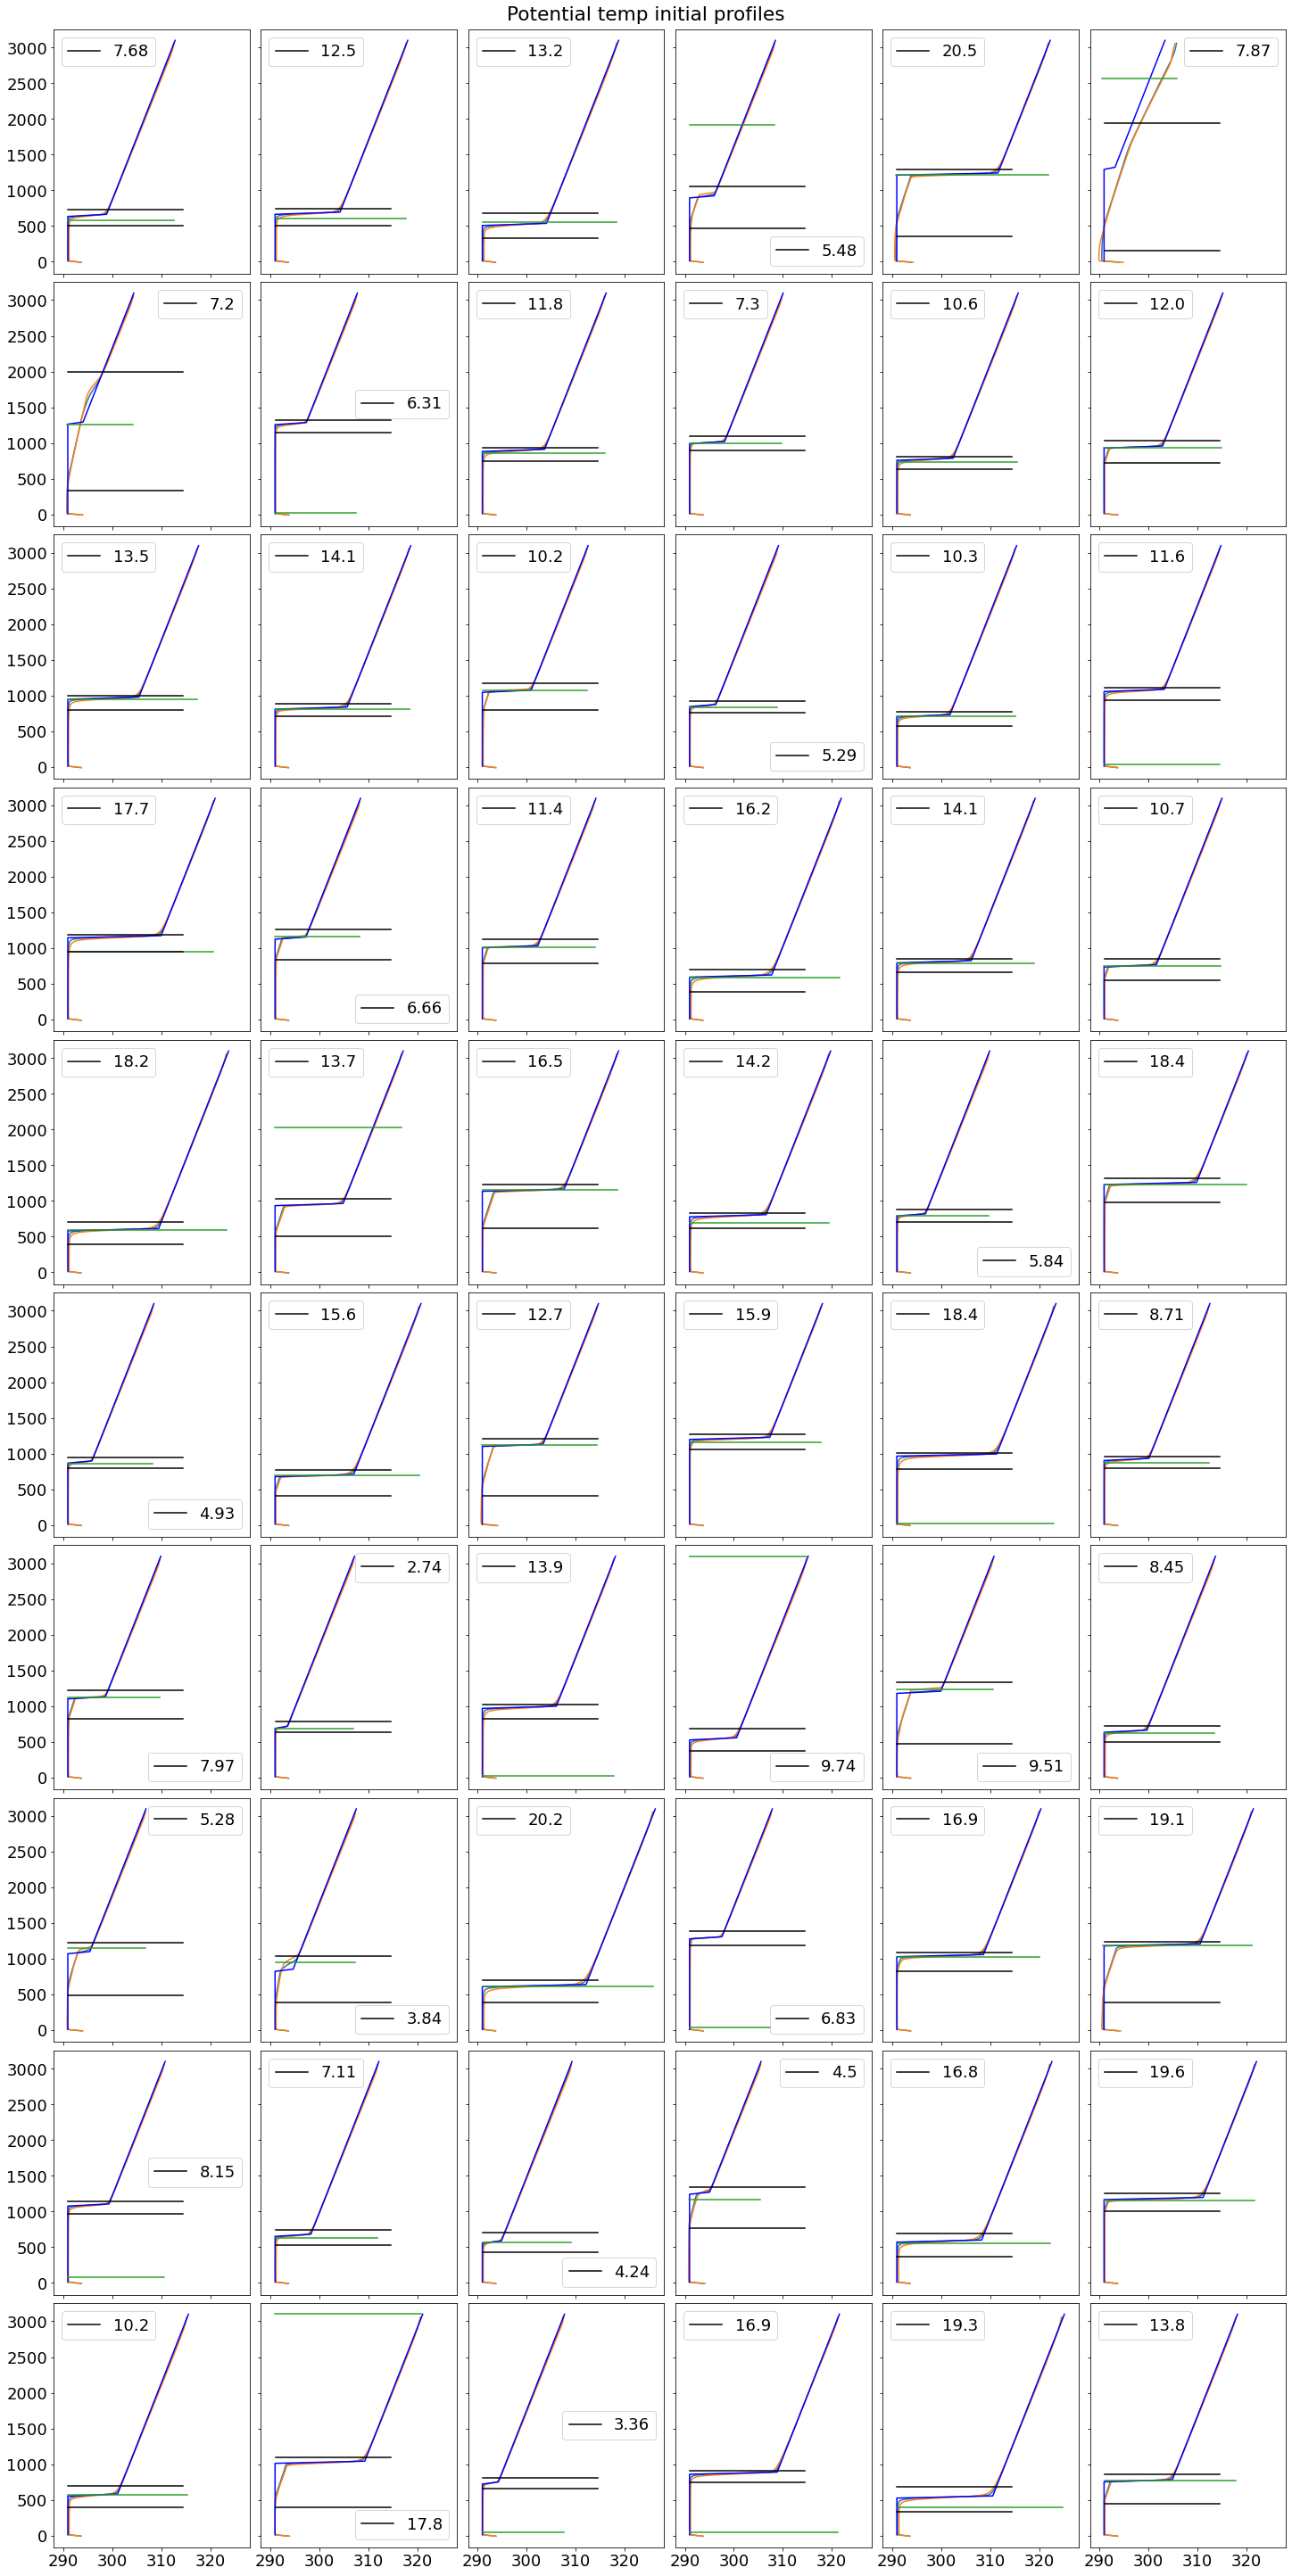

In [90]:
fig, ax = plt.subplots(nrows=10,ncols=6, figsize=(20,40), sharex=True, sharey=True, constrained_layout=True)

axes = []
for a in ax:
    for b in a:
        axes.append(b)
        
ind = 0
for a,b in zip(axes,range(1,61)):
    ds = xr.open_dataset(f'/gws/nopw/j04/carisma/eers/sct/em/em{b}/sct_em{b}_merged.nc')
    bl_z = get_blz(b, ind)
    blz_ind = np.argmin(np.abs(ds.z.values - bl_z))
    
    da=ds.theta_mean[1, 5:]
    ds.theta_mean[0].plot(y='zn', ax=a)
    ds.theta_mean[1].plot(y='zn', ax=a)
    a.plot(th_prof[b-1], heights[b-1], c='blue')
    a.plot((min(ds.theta_mean[ind]), max(ds.theta_mean[ind])), (bl_z, bl_z))

    subcloud_top, inv_ind, diff = get_deltheta_thresh(ds, 1)
    a.plot((m1, m2), (ds.zn[subcloud_top], ds.zn[subcloud_top]), c='black')
    l,=a.plot((m1, m2), (ds.zn[inv_ind+20], ds.zn[inv_ind+20]), c='black', label=f'{diff:0.3}')
    a.set_title('')
    a.set_ylabel('')
    a.set_xlabel('')
    a.legend()
    
#fig.text(0.5,0.01,"Potential temperature (K)", ha='center', va='center')
#fig.text(0.01,0.5,"Height (m)", ha='center', va='center', rotation=90)
fig.suptitle("Potential temp initial profiles")
fig.savefig("pot_temp_profiles_inv_split_winitial.png")

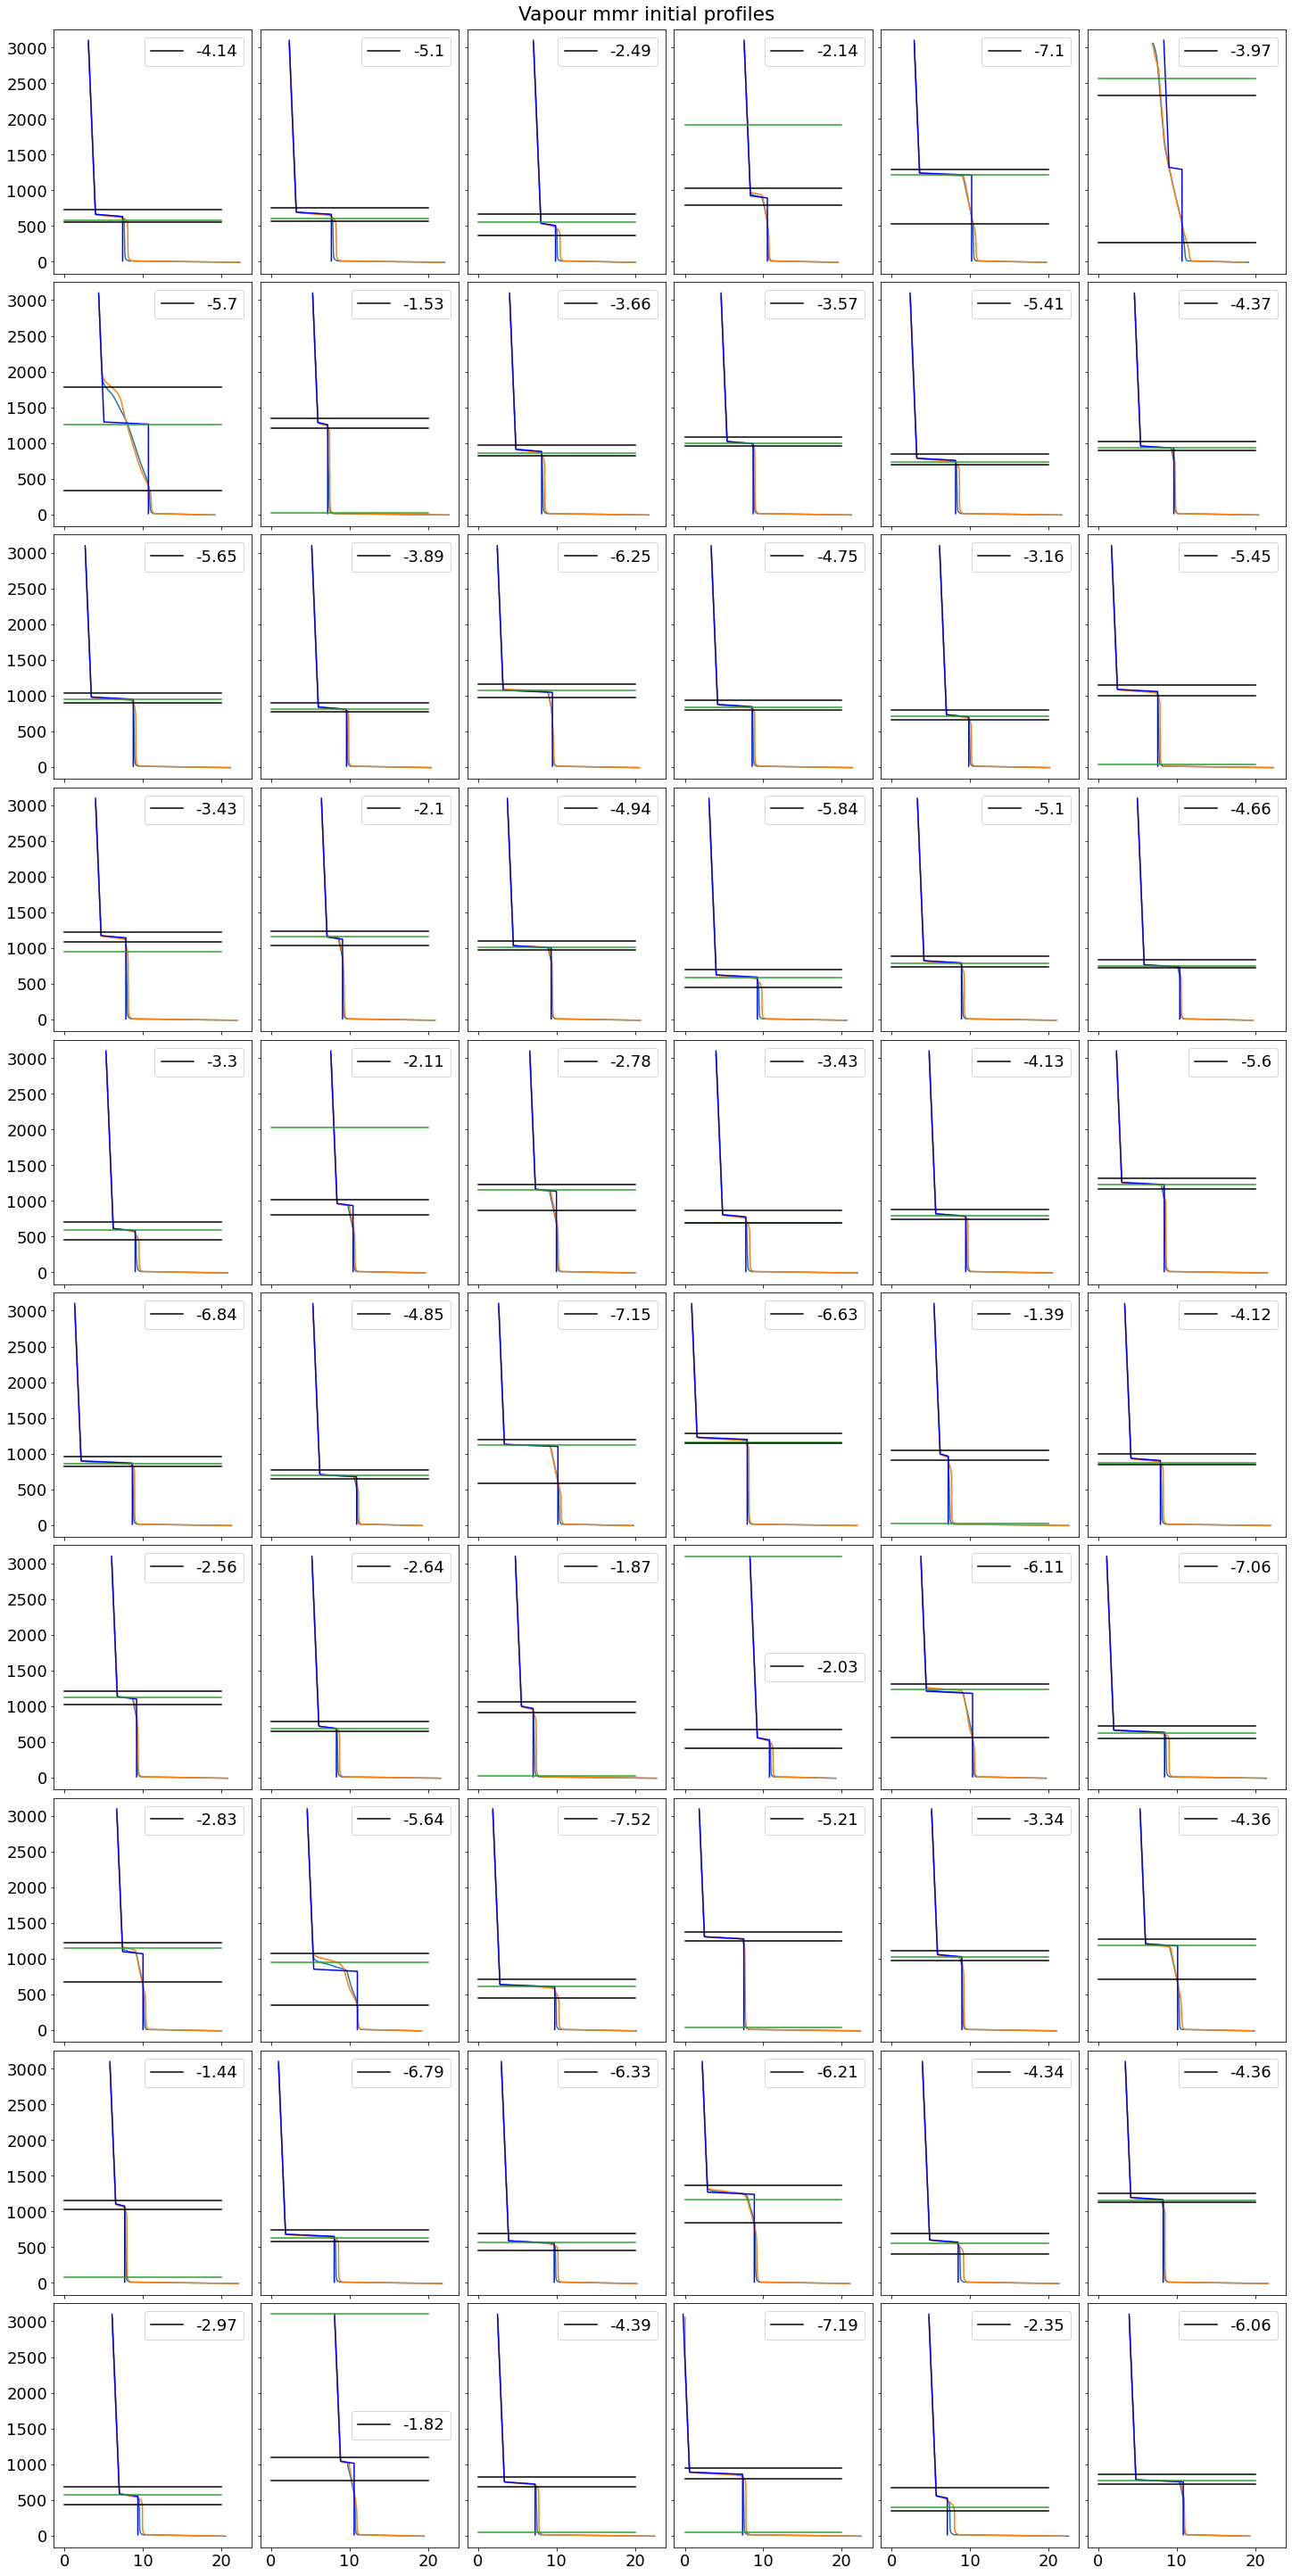

In [94]:
fig, ax = plt.subplots(nrows=10,ncols=6, figsize=(20,40), sharex=True, sharey=True, constrained_layout=True)

axes = []
for a in ax:
    for b in a:
        axes.append(b)

ind = 0
for a,b in zip(axes,range(1,61)):
    ds = xr.open_dataset(f'/gws/nopw/j04/carisma/eers/sct/em/em{b}/sct_em{b}_merged.nc')
    bl_z = get_blz(b, ind)
    blz_ind = np.argmin(np.abs(ds.z.values - bl_z))
    
    da_q = ds.vapour_mmr_mean[1,5:-2]*1e3
    zeroth=ds.vapour_mmr_mean[0]*1e3
    zeroth.plot(y='zn', ax=a)
    first=ds.vapour_mmr_mean[1]*1e3
    first.plot(y='zn', ax=a)
    a.plot(qv_prof[b-1], heights[b-1],c='blue')
    a.plot((0,20), (bl_z, bl_z))

    subcloud_top, min_grad, diff = get_delqv_thresh(ds, 1)
    
    if min_grad < 240:
        inv_ind = min_grad+20
    else:
        inv_ind = min_grad
    
    a.plot((0,20), (ds.zn[subcloud_top], ds.zn[subcloud_top]), c='black')
    a.plot((0,20), (ds.zn[inv_ind], ds.zn[inv_ind]),c='black', label=f'{diff:0.3}')
    a.set_title('')
    a.set_xlabel('')
    a.set_ylabel('')
    a.legend()
    
#fig.text(0.5,0.01,"Vapour mmr (g/kg)", ha='center', va='center')
#fig.text(0.01,0.5,"Height (m)", ha='center', va='center', rotation=90)
fig.suptitle("Vapour mmr initial profiles")
fig.savefig("vap_mmr_profiles_inv_split_winitial.png")